In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
import statistics
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../SFS/NDNS UK/ndns_edited.csv')
products = get_products()
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
products.shape

(262711, 7)

In [7]:
len(non_food_products)

39

In [8]:
labelled_data.shape

(61912, 10)

In [9]:
labelled_data[labelled_data['subfoodgroupcode'].isna()].shape

(1588, 10)

In [10]:
labelled_data[labelled_data['subfoodgroupcode'].isna()]['mainfoodgroupdesc'].value_counts()

Vegetables                              623
Breakfast cereals                       313
Buns, cakes, pastries and fruit pies    313
Bread                                   279
Sugars, preserves and sweet spreads      60
Name: mainfoodgroupdesc, dtype: int64

In [11]:
labelled_data['parentcategory'].value_counts()

Cereals and Cereal Products             13238
Non-Alcoholic Beverages                  7293
Meat and Meat Products                   6620
Vegetables, Potatoes                     6261
Sugar, Preserves and Confectionery       6078
Milk and Milk Products                   5963
Miscellaneous                            5921
Fish and Fish Dishes                     2553
Savoury Snacks                           1794
Alcoholic Beverages                      1608
Fruit                                    1427
Fat Spreads                              1173
Nuts and Seeds                           1063
Eggs and Egg Dishes                       455
Dietary Supplements                       237
Artificial Sweeteners                     156
Commercial Toddlers Foods and Drinks       72
Name: parentcategory, dtype: int64

In [12]:
labelled_data['subfoodgroupdesc'].value_counts()

Savoury sauces pickles gravies & condiments                            3924
Chocolate confectionery                                                3493
Biscuits                                                               3019
Tea (made up)                                                          2004
Crisps and savoury snacks                                              1794
Other chicken and turkey                                               1785
Pasta                                                                  1660
Yogurt                                                                 1558
Soup                                                                   1407
Buns cakes and pastries                                                1312
Other vegetable products and dishes                                    1239
Sugar confectionery                                                    1226
Ice cream                                                              1217
Pizza       

#### parent category

In [13]:
artificial_sweetners = products[(products['product_list_name'].str.contains('Stevia'))
                               & (products['extract_year']==2019)][[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store'
]]
artificial_sweetners['parentcategory'] = 'Artificial Sweeteners'
artificial_sweetners['mainfoodgroupcode'] = 55
artificial_sweetners['mainfoodgroupdesc'] = 'Artificial sweeteners'
artificial_sweetners['subfoodgroupcode'] = '55R'
artificial_sweetners['subfoodgroupdesc'] = 'Artificial sweeteners'

baby_food = products[(products['product_list_name'].str.contains('Cerelac'))
                    & (products['extract_year']==2019)][[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store'
]]
baby_food['parentcategory'] = 'Commercial Toddlers Foods and Drinks'
baby_food['mainfoodgroupcode'] = 52
baby_food['mainfoodgroupdesc'] = 'Commercial toddlers foods and drinks'
baby_food['subfoodgroupcode'] = '52R'
baby_food['subfoodgroupdesc'] = 'Commercial toddlers foods'

diet_supp = products[(products['product_list_name'].str.contains('Superfood Powder'))
                    & (products['extract_year']==2019)][[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store'
]]
diet_supp['parentcategory'] = 'Dietary Supplements'
diet_supp['mainfoodgroupcode'] = 54
diet_supp['mainfoodgroupdesc'] = 'Dietary supplements'
diet_supp['subfoodgroupcode'] = '54K'
diet_supp['subfoodgroupdesc'] = 'Other nutrient supplements'

labelled_data = pd.concat([labelled_data, artificial_sweetners, 
                           baby_food, diet_supp], ignore_index=True, axis=0).drop_duplicates(
                subset=['product_id']).reset_index(drop=True)

# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [14]:
lev0_labels_add = products[products['extract_year']==2019][[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev0_labels_add['parentcategory'] = np.NaN
lev0_labels_add['mainfoodgroupcode'] = np.NaN
lev0_labels_add['mainfoodgroupdesc'] = np.NaN
lev0_labels_add['subfoodgroupcode'] = np.NaN
lev0_labels_add['subfoodgroupdesc'] = np.NaN

lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Schwartz Mint")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pearled Spelt")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cornflour"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Sugar")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Street Kitchen")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dried Seaweed")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cavolo Nero")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Berio Balsamic Vinegar")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Emmi Caffe Latte'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Crushed Ginger")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Savers Honey"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Drinking Chocolate")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("White Hot Chocolate")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Babease"), 
                   'parentcategory'] = 'Commercial Toddlers Foods and Drinks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Pumpkin Seeds"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.lower().str.contains("bone marrow"), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Douro"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Lily's Kitchen"))
                    & ((~lev0_labels_add['product_list_name'].str.contains('Treats'))
                      | (~lev0_labels_add['product_list_name'].str.contains('Biscuits'))
                      | (~lev0_labels_add['product_list_name'].str.contains('Calendar'))), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Black Pepper Coarse")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Coriander Seeds")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Coriander Whole")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Frittatas"), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('KETTLE'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Nik Naks'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Prunes'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fullgreen")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Aunt Bessie's Sticky Toffee"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Adonis Natural"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Bare Naked")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Eat Natural Protein"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ambrosia"))
                    & (lev0_labels_add['product_list_name'].str.contains("Caramel")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Wild Rocket")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Brown Onion")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Hilltop Honeys'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Almond Extract")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Coconut Cream"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Croissant")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Bombay Mix'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Reeses Peanut Butter Cups'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Kalamata Olives'))
                    & (~lev0_labels_add['product_list_name'].str.contains('Hummus')), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Sliced Black Olives'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cadbury Brunch Bars")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Shrimps & Bananas'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Frangipane Tart")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cinnamon Sticks")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Due Vittorie Balsamic Vinegar")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ground White Pepper")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Gherkins")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chopped Garlic")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Blue Dragon"))
                    & ((lev0_labels_add['product_list_name'].str.contains("Noodle"))
                      | (lev0_labels_add['product_list_name'].str.contains("Pho"))), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Blue Dragon"))
                    & (lev0_labels_add['product_list_name'].str.contains("Curry Kit")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Poppadums'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Naked Rice'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ella's Kitchen")), 
                   'parentcategory'] = 'Commercial Toddlers Foods and Drinks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Heinz"))
                    & (lev0_labels_add['product_list_name'].str.contains("Baby")), 
                   'parentcategory'] = 'Commercial Toddlers Foods and Drinks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Batchelors Pasta'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Aubergine'))
                    & (~lev0_labels_add['product_list_name'].str.contains('Chicken')), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Ko-Lee Taste Sensation Instant Noodles'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Nescafe'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Charlie Bigham's"))
                    & (lev0_labels_add['product_list_name'].str.contains('Vegetable')), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Charlie Bigham's"))
                    & (lev0_labels_add['product_list_name'].str.contains('Chicken')), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Moroccan Medley Cous Cous'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Linda McCartney'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Headland"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Felix Goody Bag'), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Peanut Butter Nut Bars'), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Angel Delight'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cadbury Mini Rolls'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Vegetarian Cauliflower Cheese Croquettes'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Ham & Cheese Croquettes'), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Meat Croquettes'), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Chorizo Croquettes'), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Spinach Croquettes'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Potato Croquettes'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Devon Custard"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("instant custard"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Flavoured Fresh Milk"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Dog '))
                    & (lev0_labels_add['product_list_name'].str.contains('Chicken')), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Cat '))
                    & (lev0_labels_add['product_list_name'].str.contains('Chicken')), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cadbury Dairy Milk 30% Less Sugar'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Balance Stevia Chocolate Dark'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Volvic Touch Of Fruit Sugar Free'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Simplee Aloe'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Aloe Vera Juice'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Multigrain Wraps'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Superfood Powder"), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Spirulina Powder"), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Raspberry Jam'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Raspberry Jelly'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Raspberry Lemonade'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Tesco Sultanas"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Strawberries Vodka"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Pistachio Kernals"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("HiPP"), 
                   'parentcategory'] = 'Commercial Toddlers Foods and Drinks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Little Moons"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Applewood"))
                    & (lev0_labels_add['product_list_name'].str.contains("Cheddar")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Cooks' Ingredients Anglesey Sea Salt"), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cod Liver Oil'), 
                   'parentcategory'] = 'Dietary Supplements'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Fishless Fillets'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Goplana Grzeski Toffi'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Energy Drink'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Coriander Powder'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Oral Spray'), 
                   'parentcategory'] = 'Dietary Supplements'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Salsa Dip'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Turmeric Cauliflower'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Tomato & Mascapone Risotto'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cappuccino Pods'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Sushi Nori'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Escargots'), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Tropicana'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Wensleydale"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Poussin'), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('East End Popcorn'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Patak's Raita"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Moroccan Couscous')) 
                    & (~lev0_labels_add['product_list_name'].str.contains('Salad')), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Peppercorn Grinder'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Ambrosia Desserts Strawberries & Cream'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cheese Crispies'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Vegan Tropical Jelly'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Kelkin Gluten Free"))
                     & (lev0_labels_add['product_list_name'].str.contains("Cakes")), 
                     'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Wotsits'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Halloween Kids Bag'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Jelly Pot'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Mylk'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Oaty Bites'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Iron & Vitamin C'), 
                   'parentcategory'] = 'Dietary Supplements'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Creme Fraiche'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Hovis Best of Both'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Macadamia Nuts"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Hot Wing Sauce'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cheese Gourmet Popcorn'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Caramel Gourmet Popcorn'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Pecan Pie Gourmet Popcorn'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Berry-licious Gourmet Popcorn'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Rich Chocolate Gourmet Popcorn'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Pop N Choc Gourmet Popcorn'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Essentials Honey'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Costa Dolce'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Blue Dragon Sweet Chilli'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Spam")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Jeera'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Tortiglioni'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Czosnek Granulowan'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Spanish Olive'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Black Olives'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Greek Olives'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Nocellara Olives'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Olives a La Grecque Provence'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Blancmange'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Finn Crisp'), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Sauerkraut'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Callaloo'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Wine Vinegar'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Nespresso Capsules'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fajita Kit")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Twix'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Sezamki Bar'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Lyles Golden Syrup'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Wrigley'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Carte Noire'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Grape Juice'), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cous Cous Salad'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Capers'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Moong'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Profiterole'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Baking Powder'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Tesco Oregano'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Tesco Saffron'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Gingerbread')) 
                    & (lev0_labels_add['product_list_name'].str.contains('Biscuit')), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Stroopwafels'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Ciabatta Rolls'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Swede'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Maris Piper'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Cod Mornay"),
                    'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Rainbow Chard'), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('French Brie'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Edam Ball'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Spanish Tapas")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Parrs'), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Pink Lady Apple'), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Flavour Milk'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Cottage Cheese Potato'), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains('Cracker')) 
                  & (~lev0_labels_add['product_list_name'].str.contains('bread'))
                  & (~lev0_labels_add['product_list_name'].str.contains('Chocolate'))
                  & (~lev0_labels_add['product_list_name'].str.contains('Crafted by Cracker')),
                  'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Digestives'), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains('Chilli Paste'), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Reese's"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Spaghetti Pasta"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Ramen Noodle"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Relish"), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chianti"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pasta Sauce")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Fiano"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Fruit Twist"), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Barbera")) 
                   & (~lev0_labels_add['product_list_name'].str.contains("Olive Oil")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Liqueur")) 
                   & (~lev0_labels_add['product_list_name'].str.contains("Chocolate")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chutney")) 
                   & (~lev0_labels_add['product_list_name'].str.contains("Sandwich"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Poppadoms"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Veggie Rolls"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Quiche")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Jam Jar Cocktail"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Paella"))
                   & (~lev0_labels_add['product_list_name'].str.contains("paste")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Croissant"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Turnover"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Fruit Filling"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Baked Beans"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Hot Chocolate"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Fondant"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Pudding"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Praline Molton"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Molten Middles"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Fudge Cake"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Cake Dessert"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Melting Middles"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Soufflés"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Marshmallow Slices")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Craft Cider"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Marzipan"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("SAVOURSMITHS"), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Boneless"))
                   & (lev0_labels_add['product_list_name'].str.contains("Lamb")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Semi Skimmed Milk"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Milkshake"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Biscuits")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Butter "))
                   & (lev0_labels_add['product_list_name'].str.contains("Salted"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Porridge"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Almond"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Peanut"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Butter Cups"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Cookies")), 
                   'parentcategory'] = 'Fat Spreads'    
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Duck Eggs"), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Fromage Frais"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Custard Tarts"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Variety Snacks"), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Crisps"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Watermelon")), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Mature Cheddar"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Crisps"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Crisp Bakes"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Chips"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Sauce"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Bacon"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Haddock"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Thins"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Coleslaw"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Mushroom"))
                   & (~lev0_labels_add['product_list_name'].str.contains("chips"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Swirls"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Pop Corn"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Chive Dip")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pringles")), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fibre One")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Bakery On")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Carbzone"))
                   & ((lev0_labels_add['product_list_name'].str.contains("Bar"))
                     | (lev0_labels_add['product_list_name'].str.contains("Chocolate"))
                     | (lev0_labels_add['product_list_name'].str.contains("chocolate"))
                     | (lev0_labels_add['product_list_name'].str.contains("Jam"))), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Carbzone"))
                   & ((lev0_labels_add['product_list_name'].str.contains("Pasta"))
                     | (lev0_labels_add['product_list_name'].str.contains("Granola"))
                     | (lev0_labels_add['product_list_name'].str.contains("Tortilla"))
                     | (lev0_labels_add['product_list_name'].str.contains("Bread"))
                     | (lev0_labels_add['product_list_name'].str.contains("Flour"))), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Weetabix"))
                   & (~lev0_labels_add['product_list_name'].str.contains("Drink")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Weetabix"))
                   & (lev0_labels_add['product_list_name'].str.contains("Drink")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Green & Black's"))
                   & (~lev0_labels_add['product_list_name'].str.contains("hot chocolate"))
                   & (~lev0_labels_add['product_list_name'].str.contains("cocoa")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Coconut Milk"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Petit Pois"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Roasting Sauce"), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Walnut Pieces"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Jellies"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Oreo"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Yogurt"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Ice Cream"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Eggs"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Bites"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Chocolate Bar"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Instant"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Dairy Milk"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pods"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Stick"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cones"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Hot Chocolate")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Granulated Sugar"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Blue Moon"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fruit Fusion"))
                    & ((lev0_labels_add['product_list_name'].str.contains("Cl"))
                      | (lev0_labels_add['product_list_name'].str.contains("Ml"))), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Echo Fruit"), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Sour Patch"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Picnic Egg"), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Chicken Mini Roasts"), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Spanish Tortilla"), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Dip Selection"), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("And Rice"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Tuna Chunks"), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Chocolate Digestive Bars"), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Tea "))
                    & (lev0_labels_add['product_list_name'].str.contains("Pack"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Digestives")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cashews"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Soulful Brazilian"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Goodlife Picador")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Peach Slices"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Crumpets"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Butter"))
                    & (lev0_labels_add['product_list_name'].str.contains("Spread"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Peanut")), 
                   'parentcategory'] = 'Fat Spreads'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Chicken Breast"), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Halloumi Fries"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Tofu"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pad Thai")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Chickpea Curry"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Figs")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chicken & Gravy Shortcrust Pastry Pie")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chicken Tikka & Rice")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Smoothie"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cheesecake")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Smoothie"))
                    & (lev0_labels_add['product_list_name'].str.contains("Cheesecake")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Trifle")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chicken Jalfrezi")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pesto Pasta")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chicken Curry")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Caster Sugar")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Mushrooms"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Zapiekanka"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pate"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Creamed"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Soup"))
                     & (~lev0_labels_add['product_list_name'].str.contains("with")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Milky Way")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fruit Tea Loaf")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Squash, Spinach & Lentil Hotpot")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Lamb Casserole"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Mix"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Schwartz"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Erin"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Knorr")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Lamb Casserole"))
                    & (lev0_labels_add['product_list_name'].str.contains("Mix")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Apple Pie")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Iceland Thin & Crispy"))
                    & (~lev0_labels_add['product_list_name'].str.contains("French Fries")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Iceland Thin & Crispy"))
                    & (lev0_labels_add['product_list_name'].str.contains("French Fries")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cheesecake Ice Cream")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fish & Chips")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Hermesetas")), 
                   'parentcategory'] = 'Artificial Sweeteners'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Rajah")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sesame Seeds"))
                    & (~lev0_labels_add['product_list_name'].str.contains("With"))
                    & (~lev0_labels_add['product_list_name'].str.contains("with")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dried Thyme")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Jerk Paste")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dates")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Vegetable Sushi")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("sultanas"))
                    & (~lev0_labels_add['product_list_name'].str.contains("bars")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("School Bars")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sprinkles")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Beefeater")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Bastides Saucisson")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Orange Gin")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Marmalade Vodka")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cheesecake"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Sticks"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pastry"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Jelly")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Alcoholic Cordial")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Marmalade Gin")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Melon"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Watermelon Water"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Spring Water"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Halter Water Melon Sugar Free"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Gin"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Original Source Water Infusions")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Tuna Drained")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Coconut Milk Chocolate")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Gravy Paste")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dog Food")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chicken Gravy Granules")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sausage & Chips")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Waitrose PDO Chianti Classico")), 
                   'parentcategory'] = 'Fat Spreads'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Terrine"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Vegetable"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pork"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Bacon"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Chocolate"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Blueberry")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Terrine"))
                    & ((lev0_labels_add['product_list_name'].str.contains("Vegetable"))
                       | (lev0_labels_add['product_list_name'].str.contains("Chocolate"))
                       | (lev0_labels_add['product_list_name'].str.contains("Blueberry"))), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Terrine"))
                    & ((lev0_labels_add['product_list_name'].str.contains("Pork"))
                       | (lev0_labels_add['product_list_name'].str.contains("Bacon"))), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("sea bass")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Haddock &")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Popchips")), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("coconut milk")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Veggie Lasagne")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dairy Milk Marvellous")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Manuka Honey"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Tea"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Bags"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Seeds"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Vinegar"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Biscuit")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Wrigley's Extra Ice Peppermint")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cold Brew Tea")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cucumber Gin")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Willie's"))
                    & ((lev0_labels_add['product_list_name'].str.contains("100% Sambirano"))
                      | (lev0_labels_add['product_list_name'].str.contains("100% Carenero"))
                      | (lev0_labels_add['product_list_name'].str.contains("cacao Venezuelan"))
                      | (lev0_labels_add['product_list_name'].str.contains("Cacao Peruvian"))), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Willie's"))
                    & (~lev0_labels_add['product_list_name'].str.contains("100% Sambirano"))
                    & (~lev0_labels_add['product_list_name'].str.contains("100% Carenero"))
                    & (~lev0_labels_add['product_list_name'].str.contains("cacao Venezuelan"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cacao Peruvian")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Blue Dragon"))
                    & (lev0_labels_add['product_list_name'].str.contains("Sauce")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Calorie Conscious")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Wrigley's Extra Cool")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pots & Co"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Sticky Toffee Pudding")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sticky Toffee Pudding")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Peach Yoghurt")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Parmigiano Reggiano")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Houmous"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Wrap"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Burgers"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Falafel")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sage & Onion Stuffing"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pork"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Chicken"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Butcher"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Morrisons The Best Sage & Onion Stuffing Balls")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sage & Onion Stuffing"))
                    & ((lev0_labels_add['product_list_name'].str.contains("Pork"))
                       | (lev0_labels_add['product_list_name'].str.contains("Chicken"))
                       | (lev0_labels_add['product_list_name'].str.contains("Butcher"))
                       | (lev0_labels_add['product_list_name'].str.contains("Morrisons The Best Sage & Onion Stuffing Balls"))), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fiery Beetroot")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Onion Rings")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Tomato Pasta")) 
                    & (~lev0_labels_add['product_list_name'].str.contains("Sauce")),
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Tomato Pasta")) 
                    & (lev0_labels_add['product_list_name'].str.contains("Sauce")),
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Raspberries")) 
                    & (~lev0_labels_add['product_list_name'].str.contains("Smoothie"))
                    & (~lev0_labels_add['product_list_name'].str.contains("ml"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Iced"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Jelly"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Water"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Chocolate"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cereals"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Seeds")),
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Butternut Squash Nut Roast Stacks")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Mandarin Jelly")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Alpro Soya")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pepperoni"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pizza"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pasta")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pot Noodle")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Swedish Glace")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Jack Daniel's"))
                    & (lev0_labels_add['product_list_name'].str.contains("Whiskey")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Maple Syrup"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Chips"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Pecans"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Nature Valley")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Maple Syrup"))
                    & (lev0_labels_add['product_list_name'].str.contains("Pecans")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[((lev0_labels_add['product_list_name'].str.contains("Golden Linseed"))
                     | (lev0_labels_add['product_list_name'].str.contains("Brown Linseed"))
                     | (lev0_labels_add['product_list_name'].str.contains("Cracked Linseed"))
                     | (lev0_labels_add['product_list_name'].str.contains("Organic Linseed"))
                     | (lev0_labels_add['product_list_name'].str.contains("Milled Linseed")))
                     & (~lev0_labels_add['product_list_name'].str.contains("Bread")),
                     'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Thorntons Classic Collection")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Estrella Damm")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Milk Chocolate Cookies")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Star Anise"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Curd")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Lemon Curd")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Flavoured Jelly")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chilli Con Carne"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Sauce")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("IPA")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Crabbies")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Bbq Seasoning")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pukka 2 Chicken & Gravy Microwave Pies")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Jelly"))
                    & ((lev0_labels_add['product_list_name'].str.contains("Orange"))
                      | (lev0_labels_add['product_list_name'].str.contains("Strawberry"))), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Galaxy"))
                    & (lev0_labels_add['product_list_name'].str.contains("Milk")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pepper Corn Grinder")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Hotel Chocolat"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Hot Chocolat")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Hotel Chocolat"))
                    & (lev0_labels_add['product_list_name'].str.contains("Hot Chocolat")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Swizzels"))
                    & (lev0_labels_add['product_list_name'].str.contains("Mix")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("New York cheesecake")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Nut Butter"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Biscuit"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cup"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cereal"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Deliciously Ella")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Milo Activ-Go Chocolate")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Icing Pouch")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Sundae"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Nakd"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Blackcurrant Sundaes"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Kit")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Snack Noodle")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Peroni Nastro Azzurro")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Peroni Nastro Azzurro"))
                    | (lev0_labels_add['product_list_name'].str.contains("The Ned Rose"))
                    | (lev0_labels_add['product_list_name'].str.contains("Cava"))
                    | (lev0_labels_add['product_list_name'].str.contains("Apothic Inferno")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("blossom honey")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ambrosia Light Devon Custard")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Fries"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Polenta"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Chicken"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Halloumi")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Petits Pois")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Barilla Lasagne")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Mcvities Light Rich Tea Biscuits")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Tikka Masala Vegetable")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Spiced Tomato Juice")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Philadelphia Original")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Peperami")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Spaghetti Carbonara")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Knorr Herb Infusion Stock Pot")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cadbury Roses")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Smarties")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Black Treacle"))
                    & (lev0_labels_add['product_list_name'].str.contains("Lyle")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Propercorn")), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Drambuie")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Perfectly Crushed Pepper")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Califia Farms"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Cold Brew")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Lemon Jelly")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Spicy Cous Cous")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Vanilla Cones")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("vine fruit mix")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cardea")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Badger Favourites Mixed pack")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Bioglan Organic Cacao Powder")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Mango Jelly")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Genovese Pesto Verde")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Teapigs")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Birds Eye Green Cuisine")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Salaam Basmati Rice")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Kinder Surprise Egg")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Salami")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pimm's")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Pavlova")), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Meringues")), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Essential Waitrose 12 Picnic Eggs")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Titanic Dark Strong Plum Porter")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Vegetable Masala")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Toasted Coconut Chips")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Salmon Cheesecakes")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Piri Piri Chicken Pasta")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Cadbury Crunchie Ice Cream")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Coronation Coleslaw")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ravioli with Beef")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chocolate Salted Caramel")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("capers")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Buckwheat"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Daylesford")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Get More Multi Vitamins"))
                    & (lev0_labels_add['product_list_name'].str.contains("Chewing Gum")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Get More Multi Vitamins"))
                    & (lev0_labels_add['product_list_name'].str.contains("Lemmon")), 
                   'parentcategory'] = 'Non-Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Pineapple Fingers"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Organix Just Apple"))
                    | (lev0_labels_add['product_list_name'].str.contains("Organix Just Mango")), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Organix Just Oatmeal"), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Organix Just Carrot"))
                    | (lev0_labels_add['product_list_name'].str.contains("Organix Just Broccoli"))
                    | (lev0_labels_add['product_list_name'].str.contains("Organix Just Sweetcorn"))
                    | (lev0_labels_add['product_list_name'].str.contains("Organix Just Butternut")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Food Colour")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Rock Salt")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Quick Yeast")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Curry Paste")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Rajah Chana Masala")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Balsamic Vinegar Of")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dried Yeast")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Nature Valley")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Butterkist Popcorn")), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Conchiglioni")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Odlums Sr")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Crazy Jack Mixed Fruit"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Desiccated Coconut"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Jackfruit In"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Like Meat Soya"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chana Masala"))
                    & (lev0_labels_add['store'].str.contains("cook")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dunns River Nurishment")), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Gallo Family Vineyards")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Liquid Egg Whites"), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Egg Salad"), 
                   'parentcategory'] = 'Eggs and Egg Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Super Bock")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Organic Rum")), 
                   'parentcategory'] = 'Alcoholic Beverages'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ground Fenugreek")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("satay peanut sauce")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Chilli Con Carne Medium Sauce")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Gelatine"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Free")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Natural Squeezy Honey")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Marshmallows"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Kelloggs")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Aubergine, Spinach & Paneer Curry"), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Wildings Duck Crackling"), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Trail Mix"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Halva"))
                    & (lev0_labels_add['product_list_name'].str.contains("Sesame")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Deliciously Ella"))
                    & (lev0_labels_add['product_list_name'].str.contains("Balls")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Naturya"))
                    & (lev0_labels_add['product_list_name'].str.contains("Seeds")), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Graze Punchy"), 
                   'parentcategory'] = 'Nuts and Seeds'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.lower().str.contains("powder"))
                   & (lev0_labels_add['product_list_name'].str.lower().str.contains("naturya"))
                   & (~lev0_labels_add['product_list_name'].str.lower().str.contains("cacao"))
                   & (~lev0_labels_add['product_list_name'].str.lower().str.contains("acai")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.lower().str.contains("powder"))
                   & (lev0_labels_add['product_list_name'].str.lower().str.contains("naturya"))
                   & ((lev0_labels_add['product_list_name'].str.lower().str.contains("cacao"))
                      | (lev0_labels_add['product_list_name'].str.lower().str.contains("acai"))), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Taramosalata")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Halva"))
                    & (lev0_labels_add['product_list_name'].str.contains("Carrot")), 
                   'parentcategory'] = 'Sugar, Preserves and Confectionery'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Nude Popcorn"), 
                   'parentcategory'] = 'Savoury Snacks'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Tesco Mixed Fruit"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Haagen-Dazs"), 
                   'parentcategory'] = 'Milk and Milk Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("VegRoot Vegetable Pâté")), 
                   'parentcategory'] = 'Vegetables, Potatoes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Ardennes Pâté")), 
                   'parentcategory'] = 'Meat and Meat Products'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Salmon Pâté")), 
                   'parentcategory'] = 'Fish and Fish Dishes'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("De Cecco"))
                    & (~lev0_labels_add['product_list_name'].str.contains("Olive Oil")), 
                   'parentcategory'] = 'Cereals and Cereal Products'
lev0_labels_add.loc[lev0_labels_add['product_list_name'].str.contains("Raspberry Fingers"), 
                   'parentcategory'] = 'Fruit'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Avocado Dressing")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Dressing, Taste")), 
                   'parentcategory'] = 'Miscellaneous'
lev0_labels_add.loc[(lev0_labels_add['product_list_name'].str.contains("Wild Rocket"))
                    | (lev0_labels_add['product_list_name'].str.contains("Spicy Rocket")), 
                   'parentcategory'] = 'Vegetables, Potatoes'

non_food_products.extend(
    products[(products['product_list_name'].str.contains('Christmas Crackers')) 
             | (products['product_list_name'].str.contains('Silver Tree Cracker'))
             | (products['product_list_name'].str.contains('Aluminium Foil'))
             | (products['product_list_name'].str.contains('Shampoo'))
             | (products['product_list_name'].str.contains('Tampons'))
             | (products['product_list_name'].str.contains('Book'))
             | (products['product_list_name'].str.contains('Coffee Mug'))
             | (products['product_list_name'].str.contains('Ceramic Mug Set'))
             | (products['product_list_name'].str.contains('Camper Van Mug'))
             | (products['product_list_name'].str.contains('Travel Mug'))
             | (products['product_list_name'].str.contains('Mug with Socks'))
             | (products['product_list_name'].str.contains('Mug and Socks'))
             | (products['product_list_name'].str.contains('Filter Papers'))
             | (products['product_list_name'].str.contains('Collagen'))
             | (products['product_list_name'].str.contains('Tobacco'))
             | (products['product_list_name'].str.contains('Glasses Set'))
             | (products['product_list_name'].str.contains('Glasses Set'))
             | (products['product_list_name'].str.contains('Nicorette'))
             | (products['product_list_name'].str.contains('Ornament'))
             | (products['product_list_name'].str.contains('Conditioner'))
             | (products['product_list_name'].str.contains('Moisturiser'))
             | (products['product_list_name'].str.contains('Ginger Ray'))
             | (products['product_list_name'].str.contains('Body Wash'))
             | (products['product_list_name'].str.contains('Green People'))
             | (products['product_list_name'].str.contains('Cake Board'))
             | (products['product_list_name'].str.contains('Toothpaste'))
             | (products['product_list_name'].str.contains('Gisela Graham'))
             | (products['product_list_name'].str.contains('Cake Tin'))
             | (products['product_list_name'].str.contains('Kalanchoe Plant'))
             | (products['product_list_name'].str.contains('Bauble Tree Decoration'))
             | (products['product_list_name'].str.contains('Beanie '))
             | (products['product_list_name'].str.contains('Muffin Cases'))
             | (products['product_list_name'].str.contains('Candle'))
             | (products['product_list_name'].str.contains('Tumbler'))
             | (products['product_list_name'].str.contains('Mexicana, For the Love of Tacos, Nachos and Al'))
             | ((products['product_list_name'].str.contains('Inch'))
               & (~products['product_list_name'].str.contains('Pizza Express')))
             | ((products['product_list_name'].str.contains('Opener'))
               & (~products['product_list_name'].str.contains('Macadamia Nuts')))
             | (products['product_list_name'].str.contains('Earrings'))
             | (products['product_list_name'].str.contains('Face Mask'))
             | (products['product_list_name'].str.contains('Montagne Jeunesse'))
             | ((products['product_list_name'].str.contains('Bowl')) 
                & (products['product_list_name'].str.contains('cm')))
            ]['product_id'].values.tolist())

lev0_labels_add.loc[(lev0_labels_add['product_id'].isin(non_food_products)), 
                   'parentcategory'] = 'Not Food'

In [15]:
lev0_labels_add = lev0_labels_add[lev0_labels_add['parentcategory'].notnull()]
lev0_labels_add['product_list_name_lower'] = lev0_labels_add['product_list_name'].str.lower()
lev0_labels_add['ingredients_text_lower'] = lev0_labels_add['ingredients_text'].str.lower()
lev0_labels_add = lev0_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = labelled_data[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'parentcategory']].merge(
    lev0_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'parentcategory']])['product_id'].values
lev0_labels_add = lev0_labels_add[(~lev0_labels_add['product_id'].isin(dups))]
labelled_data = labelled_data[(~labelled_data['product_id'].isin(lev0_labels_add['product_id'].values))]
labelled_data = pd.concat([labelled_data, lev0_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [16]:
labelled_data = labelled_data[labelled_data['product_id'].notnull()].reset_index(drop=True)

In [17]:
labelled_data.shape

(68407, 12)

In [18]:
len(non_food_products)

1002

In [19]:
query_embeddings = np.load('../../SFS/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../SFS/bert/tsne_results_all3.npy')
product_ids = np.load('../../SFS/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
labelled_data = labelled_data.merge(features)

In [20]:
features.shape

(262711, 771)

In [21]:
labelled_data['parentcategory'].value_counts()

Cereals and Cereal Products             13640
Non-Alcoholic Beverages                  7717
Meat and Meat Products                   7092
Sugar, Preserves and Confectionery       6934
Vegetables, Potatoes                     6754
Milk and Milk Products                   6524
Miscellaneous                            6499
Fish and Fish Dishes                     2572
Savoury Snacks                           2363
Alcoholic Beverages                      2117
Fruit                                    1732
Fat Spreads                              1172
Nuts and Seeds                           1129
Not Food                                  909
Eggs and Egg Dishes                       492
Commercial Toddlers Foods and Drinks      348
Dietary Supplements                       232
Artificial Sweeteners                     181
Name: parentcategory, dtype: int64

In [22]:
mod = RandomForestClassifier(n_estimators=200, 
                             min_samples_leaf=5,
                             # max_depth=20,
                             class_weight='balanced'
                            )

acc_list_train = []
bal_acc_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []
mcc_list_train = []

acc_list_test = []
bal_acc_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
mcc_list_test = []

for i in range(1):
    train, test = train_test_split(labelled_data, test_size=0.2, random_state=i)
    X_train = train[X_cols]
    y_train0 = train[y_cols[0]]
    X_test = test[X_cols]
    y_test0 = test[y_cols[0]]
    X_pred = features[X_cols]

    print(f'Number of unique level 0 categories in train: {train[y_cols[0]].nunique()}')
    print(f'Number of unique level 0 categories in test: {test[y_cols[0]].nunique()}')
    
    clf0 = mod
    clf0.fit(X_train, y_train0)
    y_train_pred0 = clf0.predict(X_train)
    y_test_pred0 = clf0.predict(X_test)
    y_pred0 = clf0.predict(X_pred)

    print(f'Lev 0 train accuracy: {accuracy_score(y_train0, y_train_pred0)}')
    print(f'Lev 0 train balanced accuracy: {balanced_accuracy_score(y_train0, y_train_pred0)}')
    print(f'Lev 0 test accuracy: {accuracy_score(y_test0, y_test_pred0)}')
    print(f'Lev 0 test balanced accuracy: {balanced_accuracy_score(y_test0, y_test_pred0)}')

    print(f'Number of unique level 0 categories predicted in train: {len(np.unique(y_train_pred0))}')
    print(f'Number of unique level 0 categories predicted in test: {len(np.unique(y_test_pred0))}')
    print(f'Number of unique level 0 categories predicted in pred: {len(np.unique(y_pred0))}')    
    
    acc_list_train.append(accuracy_score(y_train0, y_train_pred0))
    bal_acc_list_train.append(balanced_accuracy_score(y_train0, y_train_pred0))
    precision_list_train.append(precision_score(y_train0, y_train_pred0, average='weighted'))
    recall_list_train.append(recall_score(y_train0, y_train_pred0, average='weighted'))
    f1_list_train.append(f1_score(y_train0, y_train_pred0, average='weighted'))
    mcc_list_train.append(matthews_corrcoef(y_train0, y_train_pred0))
    
    acc_list_test.append(accuracy_score(y_test0, y_test_pred0))
    bal_acc_list_test.append(balanced_accuracy_score(y_test0, y_test_pred0))
    precision_list_test.append(precision_score(y_test0, y_test_pred0, average='weighted'))
    recall_list_test.append(recall_score(y_test0, y_test_pred0, average='weighted'))
    f1_list_test.append(f1_score(y_test0, y_test_pred0, average='weighted'))
    mcc_list_test.append(matthews_corrcoef(y_test0, y_test_pred0))

Number of unique level 0 categories in train: 18
Number of unique level 0 categories in test: 18
Lev 0 train accuracy: 0.9914846962083143
Lev 0 train balanced accuracy: 0.996299198116541
Lev 0 test accuracy: 0.9131705890951616
Lev 0 test balanced accuracy: 0.8921710538380881
Number of unique level 0 categories predicted in train: 18
Number of unique level 0 categories predicted in test: 18
Number of unique level 0 categories predicted in pred: 18


In [23]:
print('train')
print(f'accuracy: {statistics.mean(acc_list_train)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_train)}')
print(f'precision: {statistics.mean(precision_list_train)}')
print(f'recall: {statistics.mean(recall_list_train)}')
print(f'f1: {statistics.mean(f1_list_train)}')
print(f'mcc: {statistics.mean(mcc_list_train)}')

print('test')
print(f'accuracy: {statistics.mean(acc_list_test)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_test)}')
print(f'precision: {statistics.mean(precision_list_test)}')
print(f'recall: {statistics.mean(recall_list_test)}')
print(f'f1: {statistics.mean(f1_list_test)}')
print(f'mcc: {statistics.mean(mcc_list_test)}')

train
accuracy: 0.9914846962083143
balanced accuracy: 0.996299198116541
precision: 0.9915894148880491
recall: 0.9914846962083143
f1: 0.9914885326275519
mcc: 0.9904895990898647
test
accuracy: 0.9131705890951616
balanced accuracy: 0.8921710538380881
precision: 0.9139057406483078
recall: 0.9131705890951616
f1: 0.9128771149194751
mcc: 0.9029363038996544


In [26]:
predicted_data = features
predicted_data['parentcategory_pred'] = pd.Series(y_pred0, index = predicted_data.index)
cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'tsne_0', 'tsne_1']

predicted_data = predicted_data.merge(products[[
    'product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text']], how='left')
predicted_data = predicted_data.merge(labelled_data[['product_id', 'product_name', 'product_list_name', 'store', 
                                                     'parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']], how='left')
predicted_data = predicted_data.rename(columns={'parentcategory': 'parentcategory_lab', 
                                                'mainfoodgroupdesc': 'mainfoodgroup_lab', 
                                                'subfoodgroupdesc': 'subfoodgroup_lab'})
predicted_data = predicted_data[cols]

In [27]:
predicted_data[(predicted_data['parentcategory_lab'].notnull())
               & (predicted_data['parentcategory_lab']!=predicted_data['parentcategory_pred'])].shape

(1079, 11)

In [ ]:
# predicted_data[(predicted_data['parentcategory_lab'].notnull())
#                & (predicted_data['parentcategory_lab']!=predicted_data['parentcategory_pred'])].reset_index(drop=True).sample(10)

In [29]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             53970
Meat and Meat Products                  27825
Non-Alcoholic Beverages                 27339
Vegetables, Potatoes                    26072
Miscellaneous                           25222
Sugar, Preserves and Confectionery      24772
Milk and Milk Products                  23575
Alcoholic Beverages                     15394
Fish and Fish Dishes                     9421
Savoury Snacks                           6622
Fruit                                    5849
Not Food                                 5125
Nuts and Seeds                           4315
Fat Spreads                              3877
Eggs and Egg Dishes                      1217
Commercial Toddlers Foods and Drinks      984
Dietary Supplements                       677
Artificial Sweeteners                     455
Name: parentcategory_pred, dtype: int64

In [30]:
# predicted_data[predicted_data['parentcategory_pred']=='Not Food'].sample(100).reset_index(drop=True)

In [31]:
clf0 = mod
clf0.fit(labelled_data[X_cols], labelled_data[y_cols[0]])
y_pred0 = clf0.predict(X_pred)

In [32]:
predicted_data = features
predicted_data['parentcategory_pred'] = pd.Series(y_pred0, index = predicted_data.index)
cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'tsne_0', 'tsne_1']

predicted_data = predicted_data.merge(products[['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text']], how='left')
predicted_data = predicted_data.merge(labelled_data[['product_id', 'product_name', 'product_list_name', 'store', 
                                                     'parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']], how='left')
predicted_data = predicted_data.rename(columns={'parentcategory': 'parentcategory_lab', 
                                                'mainfoodgroupdesc': 'mainfoodgroup_lab', 
                                                'subfoodgroupdesc': 'subfoodgroup_lab'})
predicted_data = predicted_data[cols]

In [33]:
predicted_data[(predicted_data['parentcategory_lab'].notnull())
               & (predicted_data['parentcategory_lab']!=predicted_data['parentcategory_pred'])].shape

(601, 11)

In [34]:
# fewer are really wrong

In [ ]:
predicted_data[(predicted_data['parentcategory_lab'].notnull())
               & (predicted_data['parentcategory_lab']!=predicted_data['parentcategory_pred'])].reset_index(drop=True).sample(100)[[
    'product_list_name', 'ingredients_text', 'parentcategory_lab', 'parentcategory_pred']]

In [44]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             53778
Meat and Meat Products                  27887
Non-Alcoholic Beverages                 27082
Vegetables, Potatoes                    25998
Miscellaneous                           25160
Sugar, Preserves and Confectionery      24776
Milk and Milk Products                  23683
Alcoholic Beverages                     15605
Fish and Fish Dishes                     9449
Savoury Snacks                           6646
Fruit                                    5864
Not Food                                 5047
Nuts and Seeds                           4379
Fat Spreads                              3880
Eggs and Egg Dishes                      1232
Commercial Toddlers Foods and Drinks     1057
Dietary Supplements                       721
Artificial Sweeteners                     467
Name: parentcategory_pred, dtype: int64

In [45]:
predicted_data[predicted_data['mainfoodgroup_lab'].notnull()]['parentcategory_pred'].value_counts()

Cereals and Cereal Products             12451
Non-Alcoholic Beverages                  7262
Meat and Meat Products                   6694
Vegetables, Potatoes                     6222
Sugar, Preserves and Confectionery       6033
Milk and Milk Products                   5953
Miscellaneous                            5780
Fish and Fish Dishes                     2553
Savoury Snacks                           1853
Alcoholic Beverages                      1640
Fruit                                    1398
Fat Spreads                              1170
Nuts and Seeds                            955
Eggs and Egg Dishes                       457
Dietary Supplements                       229
Artificial Sweeteners                     192
Commercial Toddlers Foods and Drinks       90
Not Food                                   20
Name: parentcategory_pred, dtype: int64

In [ ]:
# accuracy
predicted_data.sample(100)[['product_list_name', 'ingredients_text', 'parentcategory_lab', 'parentcategory_pred']]

In [ ]:
# precision 
predicted_data[predicted_data['parentcategory_pred']=='Vegetables, Potatoes'].sample(100)[[
    'product_list_name', 'ingredients_text', 'parentcategory_lab', 'parentcategory_pred']]

In [442]:
# manual corrections

# Sainsbury's Cake Decorations, Sugar Stars 43g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sugar stars")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

# Ambrosia Strawberry Flavour Devon Custard
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("devon custard")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

# Nando's Coat & Cook Hot 120G
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nando's coat & cook")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Bounce Plant Protein Maple Pecan Cashew Ball
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bounce")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

# Scrumbles Cat Dental Treats Grain Free, Gnashers
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("scrumbles")),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("scrumbles"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("salmon"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("tuna"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("fish"))),
                  'parentcategory_pred'] = 'Fish and Fish Dishes'

# Whitworths Mix & Bake Cherry & Dark Chocolate
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("whitworths mix & bake")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

# Nakd Posh Bits Cocoa Raspberry
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nakd"))
               & (predicted_data['product_list_name'].str.lower().str.contains("bar")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

# ASDA Reduced Fat Green Pesto
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("green pesto")),
                  'parentcategory_pred'] = 'Miscellaneous'

# BEPPS Salt & Vinegar Puffs
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bepps")),
                  'parentcategory_pred'] = 'Savoury Snacks'

# Grom Crema Di Grom Gelato with Biscuit & Choco
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gelato")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

# Blue Riband Original 16 Pack
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("blue riband")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

# KitKat 2 Finger Milk Chocolate Biscuit Bars Bu
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kitkat"))
                   | (predicted_data['product_list_name'].str.lower().str.contains("kit kat")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

# Grenade Carb Killa High Protein Bar White Choc
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("grenade"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("bar")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

# Loyd Grossman Tomato & Basil No Added Sugar
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("loyd grossman tomato & basil")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Scotch Pies
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("scotch pies")),
                  'parentcategory_pred'] = 'Meat and Meat Products'

# Naturediet Feel Good Puppy Complete Wet Dog Food
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dog food"))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products')
                   & (predicted_data['parentcategory_pred']!='Fish and Fish Dishes'),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dog food"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("salmon"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("tuna"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("fish"))),
                  'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cat food"))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products')
                   & (predicted_data['parentcategory_pred']!='Fish and Fish Dishes'),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cat food"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("salmon"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("tuna"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("fish"))),
                  'parentcategory_pred'] = 'Fish and Fish Dishes'

# Eat Real Hummus, Lentil, Quinoa Chips X5 116g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("eat real")),
                  'parentcategory_pred'] = 'Savoury Snacks'

# Sharwood's Chilli & Cumin Poppadoms
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("poppadoms")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pappadums")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Gama Tzatziki Dip
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tzatziki dip")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Garlic Ciabatta
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ciabatta"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cracker"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pork"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("garlic"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("olive"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("tomato"))),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Morrisons Quinoa
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("morrisons quinoa")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Tesco Dried Mint 14G
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dried mint")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Heinz 7+ Months First Steps Multigrain with Ca..
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("heinz 7+")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

# Alfresco Mediterranean Style Halloumi Fries
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("halloumi fries")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

# Daylesford Organic Goose
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("organic goose")),
                  'parentcategory_pred'] = 'Meat and Meat Products'

# Waitrose Coconut, Lime & Coriander Rice
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coriander rice")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Leksands Crispy Squares
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crispy squares")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Patricius Dry Furmint Hungary
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("patricius")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

# Tesco Kashmiri Chilli Flakes 27G
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chilli flakes")),
                  'parentcategory_pred'] = 'Miscellaneous'

# UFIT High Protein Shake Drink White Chocolate
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ufit"))
                   & (predicted_data['parentcategory_pred']=='Miscellaneous'),
                  'parentcategory_pred'] = 'Milk and Milk Products'

# Kohinoor Peshwari Dal Makhani 300g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dal makhani")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

# Aunt Bessie's Dumpling Mix
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dumpling mix")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Waitrose Cooks' Ingredients smoked paprika
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cooks' ingredients"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("paprika")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Quorn Takeaway Crunchy Fillet Burgers 190g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("quorn"))
                   & (predicted_data['parentcategory_pred']=='Meat and Meat Products'),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

# M&S Marinated Ploughmans Pot
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ploughmans pot")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

# M&S Raspberry Mojito
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raspberry mojito")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

# Naturya Organic Spirulina Powder
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("spirulina powder")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Minvita Moringa Superfood Powder
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("superfood powder")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Belvoir Raspberry Lemonade
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raspberry lemonade")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'


# Garofalo Organic Quinoa
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("organic quinoa"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("burgers"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("green people")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Chesterfield Green Super Kings
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chesterfield")),
                  'parentcategory_pred'] = 'Not Food'

# Doritos Hot Salsa Dip
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bay leaves"))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products'),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("schwartz")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Doritos Hot Salsa Dip
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("salsa dip")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Food Thoughts Roasted Cacao Nibs
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cacao nibs"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oat"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bar"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("flapjack"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bites"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chia"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("vanilla")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Morrisons The Best Bush Vine Cinsault
predicted_data.loc[(predicted_data['product_list_name'].str.contains("cinsault")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

# Morrisons Cashews
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cashews"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("morrisons"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("marmite"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("truffle nut selection"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("tyrrells"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("king"))),
                  'parentcategory_pred'] = 'Nuts and Seeds'

# Clearspring Sea Vegetable Salad
predicted_data.loc[(predicted_data['product_list_name'].str.contains("sea vegetable salad")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

# Tisserand Eucalyptus Organic Pure Essential Oil
predicted_data.loc[(predicted_data['product_list_name'].str.contains("tisserand eucalyptus")),
                  'parentcategory_pred'] = 'Not Food'

# Harvey Nichols Green Pitted Olives In Brine
predicted_data.loc[(predicted_data['product_list_name'].str.contains("pitted olives")),
                  'parentcategory_pred'] = 'Fruit'

# Ingeno Organic Nero d'Avola
predicted_data.loc[(predicted_data['product_list_name'].str.contains("ingeno")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

# Bear Yo Yo Strawbery 5 Pack
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bear yo yo")),
                  'parentcategory_pred'] = 'Fruit'

# Taylor & Colledge Organic Vanilla Bean Paste
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vanilla bean paste")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Kiddylicious Popped Hoops BBQ Flavour 3+ Years
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kiddylicious")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

# Iceland Sandwich Filler Egg Mayonnaise 200g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mayonnaise"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("prawn"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tuna"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("aubergine"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("coleslaw"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bacon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("wrap")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mayonnaise"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("prawn"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tuna"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("aubergine"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("coleslaw"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bacon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("wrap"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("sandwich"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("filler")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Bart oregano
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("oregano"))
                   & (predicted_data['parentcategory_pred'].isin(['Alcoholic Beverages', 'Fat Spreads', 
                                                                  'Non-Alcoholic Beverages', 'Not Food'])),
                  'parentcategory_pred'] = 'Miscellaneous'

# Munchy Seeds Totally Tropical Breakfast Booster
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("munchy seeds")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

# Colman's Chilli Con Carne Recipe Mix
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("recipe mix")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Together Eye Defence
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("together eye defence")),
                  'parentcategory_pred'] = 'Dietary Supplements'

# Merchant Gourmet Red & White Quinoa 250G
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("red & white quinoa")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Cofresh Coconut Bar 30G
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cofresh coconut bar")),
                  'parentcategory_pred'] = 'Fruit'

# Wild Rocket
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("wild rocket")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

# Sainsbury's Mini Raspberry Meringues 22g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("meringues"))
                  | (predicted_data['product_list_name'].str.lower().str.contains("meringue nest"))
                  | (predicted_data['product_list_name'].str.lower().str.contains("meringue shells"))
                  | (predicted_data['product_list_name'].str.lower().str.contains("meringue pavlova")),
                  'parentcategory_pred'] = 'Eggs and Egg Dishes'

# Sundora Sultana's 500g
predicted_data.loc[((predicted_data['product_list_name'].str.lower().str.contains("sultanas"))
                  | (predicted_data['product_list_name'].str.lower().str.contains("sultana's")))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("rice"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("cereal"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("nuts"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("oat"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("couscous"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("frusli"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("sourdough")),
                  'parentcategory_pred'] = 'Fruit'

# Desiccated Coconut
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("desiccated coconut")),
                  'parentcategory_pred'] = 'Fruit'

# M&S Raspberry Jam Bakes
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raspberry jam bakes")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Volvic Touch of Fruit Sugar
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("volvic")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

# Cadbury Dairy Milk 30% Less Sugar Chocolate Bar
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dairy milk 30% less sugar")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

# Gressingham Spatchcock Poussin Sea Salt & Pepper
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("poussin")),
                  'parentcategory_pred'] = 'Meat and Meat Products'

# Essential Couscous
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("couscous")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# HiPP Organic Sweet Squash & Chicken Jar, 6 mths+
predicted_data.loc[(predicted_data['product_list_name'].str.contains("HiPP")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

# Ella's Kitchen
predicted_data.loc[(predicted_data['product_list_name'].str.contains("ella's kitchen")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

# Clive's Vegan Quiche Lorraine
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegan"))
                  & ((predicted_data['parentcategory_pred']=='Meat and Meat Products')
                    | (predicted_data['parentcategory_pred']=='Eggs and Egg Dishes')
                    | (predicted_data['parentcategory_pred']=='Fish and Fish Dishes')),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

# Castello Danish Blue
predicted_data.loc[(predicted_data['product_list_name'].str.contains("castello"))
                   & (~predicted_data['product_list_name'].str.contains("red wine"))
                   & (~predicted_data['product_list_name'].str.contains("olio del castello"))
                   & (~predicted_data['product_list_name'].str.contains("castello loreto valpolicella")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

# Echo Falls Fruit Fusion Berries 250Ml
predicted_data.loc[(predicted_data['product_list_name'].str.contains("echo falls")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

# Sainsbury's Iced Finger x2
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("iced finger")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Daylesford Organic Florentines
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("florentines")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Gran Gallo Risotto
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gran gallo risotto")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Cathedral City Minis Light 6x20g
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cathedral city"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("baked"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mac 'n' cheese"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pork"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("potato"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("toastie"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cauliflower"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mash"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("focaccia"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crumbly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("quiche")),
                  'parentcategory_pred'] = 'Milk and Milk Products'


# Kombucha
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kombucha")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

# M&S Pearl Barley
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pearl barley"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("soup"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("lentils"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("prawn"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("butternut")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Humza Paratha
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("humza paratha")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Burton's Fish 'n' Chips Salt & Vinegar 6x25g - savoury snacks
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("burton's fish")),
                  'parentcategory_pred'] = 'Savoury Snacks'

# Heinz Ravioli with Beef in Tomato Sauce
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ravioli")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

# Waitrose Love Life Buckwheat
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("buckwheat"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("sweet potato"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("fish"))
                  & (~predicted_data['product_list_name'].str.lower().str.contains("beef")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("buckwheat"))
                  & (predicted_data['product_list_name'].str.lower().str.contains("beef"))
                  & (predicted_data['parentcategory_pred']!='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Meat and Meat Products'

# Fry's 4 Golden Crispy Fish-Style Fillets - vegan
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fry's"))
                   & (predicted_data['parentcategory_pred']!='Sugar, Preserves and Confectionery')
                   & (predicted_data['parentcategory_pred']!='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

# Crosse & Blackwell Ltd Roast Chicken & Vegetab - soup
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crosse & blackwell"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("whole")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Baileys Hot Chocolate Mug & Mini Whisk Gift Set - misc
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("baileys hot chocolate")),
                  'parentcategory_pred'] = 'Miscellaneous'

# Linda McCartney
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("linda mccartney"))
                   & (predicted_data['parentcategory_pred']!='Milk and Milk Products')
                   & (predicted_data['parentcategory_pred']!='Non-Alcoholic Beverages'),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

In [305]:
# more corrections

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('seafood cocktail')),
                  'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('chocolate cocktail')),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('gingerbread'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('kit')),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cous cous'))
                   & (predicted_data['parentcategory_pred'].isin(['Alcoholic Beverages', 'Non-Alcoholic Beverages', 'Milk and Milk Products'])),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('pink salt'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chocolate'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('doisy & dam'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('karma bites'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chips'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('nuts')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pink himalayan"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("purl pop")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cocktail vienna')),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('apple sauce'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('hog roast'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('pork')),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('crushed chilli'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('soup'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('pasta')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("l'or espresso")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("saffron"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("risotto")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("saffron"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("risotto"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rice"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("paella"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chai"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("potatoes"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lentil"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("saffron tree"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("kombucha"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("olive oil")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vinegar"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crisps"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chips"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beetroot"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("gherkins"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("walnuts"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mccoy's"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fish"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("snack"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hula hoop"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rice cake"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("peanuts"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cracker"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("onion"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("puffs"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ringos"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beets"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cucumber"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("twirls"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("keogh's"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tyrrells"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lamb"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salt &"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salt and"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("stick"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("kombucha"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cockles"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("kevita"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pickled"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("purearth"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yushoi"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("well & truly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lost coast"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lo bros"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("corkers"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("kallo"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sourdough"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("anchovies"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("capers"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("garlic"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pork"))
                   & (~predicted_data['product_list_name'].str.contains("OSU"))
                   & (~predicted_data['product_list_name'].str.contains("Osu")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('crunchips')),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('ogorki')),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("agave"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("drink"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tequila"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dressing"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sauce")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cactus"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("decoration"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("erbology"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fajita"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oil free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hydrea london"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sliced")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cactus"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("erbology")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cactus"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("fajita"))
                      | (predicted_data['product_list_name'].str.lower().str.contains("sliced"))),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tesco cardamon")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cardamom"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("water"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("franklin & son's"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("london essence"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pukka"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("loveraw"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("preserves"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("little's"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chai"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bitters"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fiovana"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("shortbread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("levantine"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sekforde")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("krowkowy")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ferrero"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("grand")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ferrero"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("kinder milk")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pesto rosso")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cumin"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("falafel"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rice"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lamb"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("olive"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hurly burly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sharwood"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oil"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("drink"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pep & lekker"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("together wholeherb"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("waffle"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bakery"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("munchy"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sourdough"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hummus"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("levantine"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("houmous")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lindor")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("red borsch")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("natco"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("dal")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("east end"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("dal")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bigos")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("muscovado"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("joint"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("schweppes"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ham"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("gammon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salmon")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raffaello")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("champignon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soup")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pure heaven")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

In [306]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("snack pack mango")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dried mango")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dairylea snacker")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("primula cheese")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cadbury twin")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mixed olives")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("custard"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("heinz")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("custard"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("slices"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tart"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("doughnut"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rhubarb and custard"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rhubarb & custard"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bird"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("squashies"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("food heaven"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("custard cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chandelier cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("brothers rhubarb"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sweets"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fellows free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cake"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("jelly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("waffle"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("heinz"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crumble"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("croissant"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soda"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("buns"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("strudel"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("donut"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rhubard & custard")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("philadephia")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rolo mousse snack bar")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coconut oil alternative")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("panna cotta")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("activia")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kirsch mousse")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chorizo & gouda")),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("linwoods")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("iced fruit bar")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bag of bones")),
                  'parentcategory_pred'] = 'Not Food'

In [121]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nakd")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tiramisu")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'


predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("very berry trifle spread")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("trifle"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("very berry trifle spread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (predicted_data['parentcategory_pred']!='Not Food'),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fanta raspberry")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raspberry"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("vitamin"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("trifle"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fanta"))
                   & (predicted_data['parentcategory_pred']=='Dietary Supplements'),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("livia's dunx peanut butter & jelly")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jelly ball")),
                  'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jelly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mushroom"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("meat"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fish"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("happy birthday"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cat food"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dog food"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("felix"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salmon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("senior cat"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("kitten"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("adult land"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tuna"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hot pepper"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("seafood"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("livia's dunx peanut butter & jelly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("custard"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("grass jelly drink"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("teapigs"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("red cabbage"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beef"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("venison"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("poultry"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cat pouch"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dog pouch"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("athena jelly adult 1+"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hilife its only natural"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sweet chili"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("caribbean pepper jelly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("jelly ball"))
                   & (predicted_data['parentcategory_pred']!='Not Food'),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

In [ ]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cheesecake'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ice cream'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('salmon'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('jelly'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('thorntons'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('greek style yogurt')),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('wham '))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('loll'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ice duos'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('spring water'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('rocket')),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('brew city'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('last order fries'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('onion'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('potato'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('pickle')),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('taramasalata')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('tiramisu yogurt')),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('nature valley'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('protein'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('oats'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('soft bake'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('soft-bake')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('nine dark chocolate')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('lajkonik')),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cheese puffs')),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cheese snack mix')),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('real handful'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bundlz')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('organix')),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('edgard & cooper'))
                   & (predicted_data['parentcategory_pred']=='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('kind protein')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('rainbow star')),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('daylesford'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('fruit & nut')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nature's heart"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('powder'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('cacao')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nature's heart"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('cacao powder')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nature's heart"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('cacao powder'))
                   & (predicted_data['parentcategory_pred']=='Non-Alcoholic Beverages'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nature's heart"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('sugar'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('almond'))
                   & (predicted_data['parentcategory_pred']=='Sugar, Preserves and Confectionery'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nature's heart"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('powder'))
                   & (predicted_data['parentcategory_pred']=='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('laythams')),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('tomato pesto')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mushroom pate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('pork')),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('babease')),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cake decor rainbow')),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's cake decoration")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("waitrose flaxseed")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("good4u"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('seeds'))
                   & (predicted_data['parentcategory_pred']=='Vegetables, Potatoes'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("good4u"))
                   & (predicted_data['parentcategory_pred']=='Non-Alcoholic Beverages'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("good4u"))
                   & (predicted_data['parentcategory_pred']=='Alcoholic Beverages'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("good4u"))
                   & (predicted_data['parentcategory_pred']=='Meat and Meat Products'),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("good4u"))
                   & (predicted_data['parentcategory_pred']=='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("wild trail")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('heinz'))
                   & ((predicted_data['product_list_name'].str.lower().str.contains('mths+'))
                     | (predicted_data['product_list_name'].str.lower().str.contains('months'))),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("deliciously ella"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('granola'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('oat '))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('muesli'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('energy ball')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("deliciously ella"))
                   & (predicted_data['parentcategory_pred']=='Alcoholic Beverages'),
                  'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['parentcategory_pred']=='Dietary Supplements')
                   & ((predicted_data['product_list_name'].str.lower().str.contains('powder'))
                     | (predicted_data['product_list_name'].str.lower().str.contains('blend'))
                     | (predicted_data['product_list_name'].str.lower().str.contains('superfood'))),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('yeast'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('extract')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("green origins"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("quinoa"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("matcha"))
                   & (predicted_data['parentcategory_pred'].isin(['Cereals and Cereal Products', 'Milk and Milk Products',
                                                                  'Vegetables, Potatoes', 'Dietary Supplements', 'Fruit',
                                                                  'Non-Alcoholic Beverages'])),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("green origins"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("quinoa")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("green origins"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('cacao powder')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("green origins"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('cacao butter')),
                  'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("green origins"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('bee pollen')),
                  'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('fuel oat')),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tahini"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains('spread'))
                     | (predicted_data['product_list_name'].str.lower().str.contains('cocoa'))),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tahini"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('houmous'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chicken'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('aubergine'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('cauliflower'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('sauce'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('dressing'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('spread'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('cocoa')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tate & lyle")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("alara organic"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('linseed')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rice wine"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('liquorice')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("birds eye veggie power")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cooks' ingredients pad thai meal kit")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pizza topper")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mozzarella pearls")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("basil pesto"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('flatbread'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bruschetta'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ciabatta'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('focaccia'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('pizza'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ravioli'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('girasoli'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tortilla'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('lasagne')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sev ")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cofresh cornflake")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sensations"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chocolate'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('hovis'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tropicana'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('cous cous'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('felix'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('nuts')),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sensations"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('nuts')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("zeastar kalamariz")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sheese")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("prewetts"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('flaxseed')),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("asahi")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("paleo foods")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("yeast"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('extract'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('hovis'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('yeastie'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('yeast free')),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("yeastie")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gamon")),
                  'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("decorations bee")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegebears")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("whitworths"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('currants')),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("noberasco"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('fruit')),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("berry mix"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('jelly'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('yogurt'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('cheesecake'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('nut'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('seed')),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("berry mix"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains('nut'))
                     | (predicted_data['product_list_name'].str.lower().str.contains('seed'))),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cranberries"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('granola'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bread'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chocolate'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('yogurt'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('grain'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('nature valley'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('eat natural'))
                   & (predicted_data['parentcategory_pred']=='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gel sachets")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit mix"))
                   & (predicted_data['parentcategory_pred']=='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gooseberry fruit"))
                   & (predicted_data['parentcategory_pred']=='Cereals and Cereal Products'),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("naturya"))
                  & (predicted_data['product_list_name'].str.lower().str.contains("breakfast")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ugg "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hugg ")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("shelled hemp")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

In [132]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bronze crunch")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coat 'n cook hot")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sesame snaps")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ginger mousse")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("wonderful pistachios")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("baking block")),
                  'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jazzie sprinkles")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("eat natural fruit & nut")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("free from mature cheddar")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegan blue block")),
                  'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seaweed crunch")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("flax pumpkin crackers")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("silver balls")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rainbow drops")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chocolate teacakes")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("muller corner crunch")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kings elite snacks"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("veg")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("white chocolate chips")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("idahoan"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("mash")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fibre one"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("caramel")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fibre one"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("peanut butter")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("topcorn")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vinegar keto crunch")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tesco mango"))
                   & (predicted_data['product_list_name'].str.contains("G"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("jelly"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chutney"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bar")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit yo yo")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fava protein chunks")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("de cecco"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("sauce")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cirio"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("sauce")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("socks, size")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("essential"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("mixed fruit")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sortett")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jel red sachet")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sproud barista")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coloured icing")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon icing")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon frosting")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cake decor"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("unicorn")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rocky road mini bites")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("unicorn confetti")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tiffin selection")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rice malt syrup")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("white miso paste")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gochujang"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cofresh jeera para")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("black bean cracker")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seed corn chips")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheddar cheese twist")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("natural corn chips")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("evan evans")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("shiraz")),
                  'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("natracare organic cotton")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant pioneers")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("estrella dipmix")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit & seed mix")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mths+"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("porridge")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("salted caramel mousse")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("anglesey sea salted & caramel")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("maggi so juicy")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("snack raisins")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("little freddie")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit, nut & soya")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chopped apricots")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gluten free latte treat")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("larabar"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("fruit & nut")),
                  'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mushroom & spinach crispbake")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese savouries")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pesto quiche")),
                  'parentcategory_pred'] = 'Eggs and Egg Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mozzarella sticks")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pizza sauce")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese snack pack")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mozzarella scamorza")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chocolate melt in the middle")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("percy pig")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("paella"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("seasoning"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("paste"))),
                  'parentcategory_pred'] = 'Miscellaneous'

In [206]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jacob"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("cheddar")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("milkshake mix")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("balconi snack")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bio360")),
                  'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("starbucks")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kubus")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bonne maman salted caramel"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("spread")),
                  'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheddar"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("roll"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sausage"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bacon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ham"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chorizo")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheddar & cracked black pepper")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("gateau")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese tasters")),
                  'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon curd"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("tart"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("muffin"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("roll"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("biscuit"))),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon curd"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yogurt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yoghurt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("skyr"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yeo valley"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tart"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("muffin"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roll"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cake")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("custard powder")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("multipack dips")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("recovery powder")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("capri-sun")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("go ahead")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit bowl")),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("annabel karmel")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("broccoli cheese"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("heinz")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("broccoli cheese"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("heinz")),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("tart")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese straws")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("sandwich"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("filler"))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products')
                   & (predicted_data['parentcategory_pred']!='Fish and Fish Dishes'),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("viennese")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("profiterole")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tartan")),
                  'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tart"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tartar"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("start"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("brew"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("nakd"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tartan"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("juice"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dinner lady"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("gelato"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hartley's 10"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hartleys 10"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yogurt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yoghurt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("granny smith apple"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("red pepper"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roasted pepper"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("onion"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rosemary"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chewy candy"))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products')
                   & (predicted_data['parentcategory_pred']!='Vegetables, Potatoes')
                   & (predicted_data['parentcategory_pred']!='Fish and Fish Dishes'),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tart"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("red pepper"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("roasted pepper"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("onion"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("rosemary"))),
                  'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coffee & caramel cake")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("piccolo"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cherry tomatoes"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("vine tomatoes"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sainsbury"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("morrison"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("coffee")),
                  'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dessert sauce")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("milkteeth")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("victoria sponge")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("milk shake powder")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chai latte powder")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("iced coffee"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cake")),
                  'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("protein powder")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ryvita thins")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese bloomer")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cadbury flake chocolate dessert")),
                  'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("muller rice")),
                  'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cream of tartar")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("harissa paste")),
                  'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fatface")),
                  'parentcategory_pred'] = 'Not Food'

In [29]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("smoked haddock")),
                  'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("the great character")),
                  'parentcategory_pred'] = 'Not Food'

In [198]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('olive'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('tapenade')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('olive pesto')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('olive roll')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

# moving olives from veg to fruit category (incorrectly classified earlier)
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('olive'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('oil'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ciabatta'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('hummus'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('biolive'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chardonnay'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('olivet'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('focacc'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chips'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('crackers'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('spread'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ghee'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('olive roll'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('palmiers'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('ghee'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('castillo de canena'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bread'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('oliver'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('olive pesto'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tapenade'))
                   & (~predicted_data['parentcategory_pred'].isin(['Not Food', 'Meat and Meat Products', 'Milk and Milk Products', 'Fish and Fish Dishes',
                                                                   'Miscellaneous', 'Cereals and Cereal Products'])),
                  'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('olive'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('pilchard')),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('corkers olive oil')),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('for goodness shakes'))
                  & (~predicted_data['product_list_name'].str.lower().str.contains('bar')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('raspberry conserve')),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('olive'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('anchov'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('paste'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tapenade')),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('fragata'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('anchov'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('paste'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tapenade')),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('bolands jersey creams')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('kinder surprise egg')),
                   'parentcategory_pred'] = 'Eggs and Egg Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('almond extract')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('lemon extract')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('peppermint'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('extract')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('brussels pâté')),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('brussels pate')),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('ardennes spreadable')),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('massage oil')),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('soaps soap')),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('vitamin e oil')),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('body butter')),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('jojoba oil')),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('lambrini original')),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('neck oil')),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('almond creme')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('waitrose orzo')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('heavenly'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('breadsticks')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('uht cooking cream')),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('garlic spread')),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('seriously strong'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('cheese')),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('butter cream vanilla')),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('garlic puree'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('olive')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('d3 drops')),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('chargrilled'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('oil')),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('golden sultana')),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('essential currants')),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('golden linseed'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bread')),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('sweet granules')),
                   'parentcategory_pred'] = 'Artificial Sweeteners'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('kippers oil')),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("udo's choice"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('powder')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("udo's choice"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('capsule')),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('durum wheat panini')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

In [205]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('aarne & elsa')),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('dolmio 7 vegetables')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('matzos')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('coriander seeds')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('super puffs')),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('salad topper'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('sprout'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tuna'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('coconut'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('middle east')),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('camembert'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bacon'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('quiche'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('mushroom')),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cheese & onion bakes')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('kofta seasoning mix')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cockles')),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('taco seasoning mix')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cashew tray')),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('bart bouquet')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('bart black')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('bart white')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('bart celery')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('bean slices')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('seabrook')),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cookbook')),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('easy peeler bermondsey')),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('whole kalamata')),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('weight watchers'))
                   & (predicted_data['product_list_name'].str.lower().str.contains('melt')),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('love life quinoa')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('ruby port'))
                   & (predicted_data['parentcategory_pred']=='Miscellaneous'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('ruby port'))
                   & (predicted_data['parentcategory_pred']=='Vegetables, Potatoes'),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('ambrosi parmigiano reggiano')),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cream of asparagus')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('cofresh chilli & lemon')),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains('garlic salt')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("peter's yard")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("battered goujons")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("super seeds"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('rice cake'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('teabag'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('porridge'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('gluten free'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('seeds white')),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("spanish omelette")),
                   'parentcategory_pred'] = 'Eggs and Egg Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("basa fillets")),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("baxters plant based")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("demae ramen")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bean & sausage slice")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegan margherita")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese nuggets")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fair trade quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("quinoa"))
                   & (predicted_data['parentcategory_pred'].isin(['Fruit', 'Alcoholic Beverages', 
                                                                  'Nuts and Seeds', 'Non-Alcoholic Beverages'])),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("quinoa"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('soup'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('broth'))
                   & (predicted_data['parentcategory_pred']=='Miscellaneous'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cypressa quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("british quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("british white quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ready to eat quinoa ")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("red and white quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("spanish quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("drained quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("red & black quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tesco quinoa 300g")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("freekeh & quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("spelt, quinoa, red rice")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("black & red quinoa")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("quinola kids")),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("quinola"))
                   & (predicted_data['product_list_name'].str.lower().str.contains('quinoa'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('kids')),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hemp milk")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("aglio olio peperoncino")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ground black pepper"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('tyrrells')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raita"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chicken'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('bhaji')),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("white peppercorns")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cooking sake")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's cous cous")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ground cloves")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dried coriander"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('gourmet garden')),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dried thyme")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coriander honey")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cous cous"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ella's kitchen"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('chargrilled'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('stuffed'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('scratch'))
                   & (~predicted_data['product_list_name'].str.lower().str.contains('roasted vegetable'))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products')
                   & (predicted_data['parentcategory_pred']!='Fish and Fish Dishes'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cous cous"))
                   & ~(predicted_data['product_list_name'].str.lower().str.contains("ella's kitchen")),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vermicelli nests")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("walkers ready salted")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegan original slices")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tyrrells"))
                   & (predicted_data['parentcategory_pred']!='Nuts and Seeds'),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese & chive dip")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("popping corn")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bouillon")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("barley groats")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("squares salt &")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("loved & found")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("enchilada kit")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("deliciously ella sweet potato chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("clearspring"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("m&s"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chiplets")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("m&s"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("potato chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("koikeya"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("potato chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("proper chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hippeas")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("properchips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tortilla chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plantain chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

In [255]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ketchup"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fillet"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("frozen"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bacon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("wrap"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cheetos"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sausage"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("decoration"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crisps")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("love corn")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("inkas gf")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("salted corn"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cake")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("off the eaten path lightly salted corn")),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("terra chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("baking beans")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ella's kitchen")),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("walkers french fries")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("genius"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("bloomer")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" pate"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("cheddar")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" pate"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("poultry"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("rustic country"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("chopped liver"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("gold pate collection"))),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bfree")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nigella seeds")),
                   'parentcategory_pred'] = 'Miscellaneous'

In [352]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sumac"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("levantine"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beetroot"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bread")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ground coriander")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("squeezy honey")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("venison")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("onion sourdough")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant pioneers"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("noodles")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant pioneers"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("mayo"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("ml")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's onion"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("fontal cheese flatbreads")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cow & gate")),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("haggis"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("veg")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lamb filo")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("confit duck")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cane sugar")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hobgoblin ruby")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("aminos")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bean sticks")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chia pasta")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant pioneers"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("block")),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("soupologie")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("alhambra reserva")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ground turmeric")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("turmeric powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hp fruity sauce")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("paprika powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mustard seed"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" with ")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("peri-peri seasoning")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("black peppercorns"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" chips ")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pop corn kernels")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ginger snaps")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("unheated thyme honey")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("doves farm free from vitamin c")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("italian olives")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chicken tomato and basil pasta")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("potato milk")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("beef pasty")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("walkers oven baked")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("roasted peas chocolate")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hodmedods roasted peas")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pea fusilli")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("yushoi")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pancetta"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pasta sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("carbonara sauce")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pea"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("fraiche"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" cod ")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plain tortilla")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("roast potato seasoning")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("butternut squash soup")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rich italian beans")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

In [359]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("deliciously ella"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chips")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fish n chip")),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("levantine"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("pitta")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

In [145]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("capsicana"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("fajita kit")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("goose fat"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roast")),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chicken cooking sauce")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("broth"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("brother")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("curry leaves")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hari tropimix")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("colman's"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chicken mix")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dunn's"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("seasoning")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cauliflower wings")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("stuffing mix")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("squeaky bean")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("capers"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fish"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("anchovy"))
                    & (~predicted_data['product_list_name'].str.lower().str.contains("pasta")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("capers"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("pasta sauce")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("stock cube")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("salmon wellington")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("meat free")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegetarian butcher")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant based"))
                   & (predicted_data['parentcategory_pred']=="Meat and Meat Products"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegetarian sandwich")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("meat-free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("stock cube")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fridge raiders"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("veggie")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("smoked chilli harissa")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cheese slices"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("mexicana"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("Auricchio"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("smoked"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("flavoured"))),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" lard"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" lardon")),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("buffalo mozzarella"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pizza")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("negroni coppa")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fridge raiders"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pork"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("meat-free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("meat free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roast"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("southern"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("veggie")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sandwich filler cheese")),
                   'parentcategory_pred'] = 'Eggs and Egg Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mccain street fries")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jackfruit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pizza"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soup"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("baxters"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crust")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("munch giants")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("woodfired"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("shiraz")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant-based"))
                   & (predicted_data['parentcategory_pred']=="Meat and Meat Products"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegilantes")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vivera")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nooch")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ross & ross"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("oil")),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ross & ross"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oil")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("salmon pate")),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

In [32]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant-based"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("loma linda"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plantlife"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fishless"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crab free"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seaweed snack")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seaweed thins")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("duck"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chicken dinner"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hilife it's only natural the big mature"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("agar flakes")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("blue shark")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sea salt flakes"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seafood seasoning")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pearled spelt")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seafood cup noodles")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("goldfish colours crackers")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fish stock")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("whiskas pure delight")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

In [15]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plant based"))
                   & (predicted_data['parentcategory_pred']=="Fish and Fish Dishes"),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crystal sea salt")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("maldon sea salt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("butter")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("love you sweets")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

In [147]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("conchiglie rigate")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sweet chilli tortillas")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("popcorn maize")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("maize kernels")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("manomasa")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("black bean stir-fry sauce")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("peppercorns"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chips"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beef"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mackerel")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("5 spice")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chinese five spice")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("redskin peanuts")),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("players superkings")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("homepride extra veg")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("buffalo dip")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("minute instant")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("parsnips"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chips"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ella's kitchen")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("goodfella's stonebaked")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("egg mayo")),
                   'parentcategory_pred'] = 'Eggs and Egg Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mushroom wellington")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("plantliving"))
                   & (predicted_data['parentcategory_pred']!='Sugar, Preserves and Confectionery'),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("love your veg"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soup"))
                   & (predicted_data['parentcategory_pred']!='Cereals and Cereal Products'),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("wicked kitchen"))
                   & (predicted_data['parentcategory_pred']=='Meat and Meat Products'),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lime leaves")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bulmers")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pomegranate juice")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pineapple sauce")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lollies"))
                   & (predicted_data['parentcategory_pred']!='Milk and Milk Products')
                   & (predicted_data['parentcategory_pred']!='Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lolly"))
                   & (predicted_data['parentcategory_pred']!='Milk and Milk Products')
                   & (predicted_data['parentcategory_pred']!='Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("poilane rye")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("smirnoff cider")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("white tea")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("applewood"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bacon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ham"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("burger"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("turkey"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("peanuts"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("haddock"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pie"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("wheel"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("block")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("applewood"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("block")),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("orange juice")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon drizzle slice")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon sole")),
                   'parentcategory_pred'] = 'Fish and Fish Dishes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("stainless steel")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hand wash")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("twinings"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("tea")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("twinings"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tea")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("banana chips"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chocolate")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("banana chips"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate")),
                   'parentcategory_pred'] = 'Fruit'

In [59]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("traybake"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chocolate")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("melting middles")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cream liqueur")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cacao powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("horlicks chocolate")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cadbury instant chocolate")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("haagen dazs")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cocio classic chocolate milk")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("calcium soft jell")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vitamin gum")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vegan ice cream")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("harissa spiced nut")),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("wonderful pistachios")),
                   'parentcategory_pred'] = 'Nuts and Seeds'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pear halves in light syrup")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("creamed coconut")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jam pudding")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's vanilla flavour"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("scoop"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vanilla extract")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("stollen")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

In [87]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("molten middle")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coffee pods")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("noodles salad")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("creamy makhani curry")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rice meal")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("caesar salad"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dressing")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jalapeno peppers"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("olive")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("daal"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soup"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("green saffron")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("beetroot"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("pickle")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("casserole vegetables")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("snap pots"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bean")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("beet it")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mugshot")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("apetina")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("delicato"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tart")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cacao nibs"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" oat "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("flapjack")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coffee sachets")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nescafe gold")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nescafe azera")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("nescafe original")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("instant latte")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tassimo"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("latte"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("coffee"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("cappuccino"))),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

In [475]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("horlicks")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crusha")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("philadelphia")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("patatas bravas")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("stir fry mix")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("beef bolognese"))
                   & (predicted_data['parentcategory_pred']!='Commercial Toddlers Foods and Drinks'),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cacao"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rose water"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("waitrose water"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("delights"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("original source")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("original source")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("water delights")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("orange blossom water")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ovaltine")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" dal ")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kurkure")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("water chestnut")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chestnut puree")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chestnut"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("gefen")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chestnut"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("turkey"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pork"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("stuffing"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("gammon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salmon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("egg"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bacon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("water"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roasted"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mushroom"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("puree"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roaster"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("flour"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("caramel"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("candied"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sprouts"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("honey"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lentil"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("grains")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemons"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("preserved")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chestnut roaster")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chestnut"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("caramel"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("candied"))),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("in juice")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("in syrup")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("princes"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("in syrup")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("urban fruit")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("f&f"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("shape")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("innocent kids")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bubble t")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cartwright & butler"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("teatime")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cartwright & butler"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("bread")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cartwright & butler"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("time edition"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("almond"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("viennese"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("digestives"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("savoury")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("staffords bakery")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mcvitie"))
                   & (~predicted_data['ingredients_text'].str.lower().str.startswith("milk chocolate", na=False))
                   & (~predicted_data['ingredients_text'].str.lower().str.startswith("milkchocolate", na=False))
                   & (~predicted_data['ingredients_text'].str.lower().str.startswith("chocolate", na=False))
                   & (~predicted_data['ingredients_text'].str.lower().str.startswith("iced gems", na=False))
                   & (~predicted_data['ingredients_text'].str.lower().str.startswith("plain chocolate", na=False))
                   & (~predicted_data['ingredients_text'].str.lower().str.startswith("caramel", na=False)),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("led tea")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tea towel")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("micellar")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("halter")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("haribo")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("whitener")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("weetabix"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("drink")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("linda mccartney"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("drink")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("caribbean twist")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("alcoholic"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("non"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" ice ")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sambucol black")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" rum "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pie"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cake"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ritter sport"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("praline"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("duck"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pudding"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("non"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" not "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" gin "))
                   & (predicted_data['product_list_name'].str.lower().str.contains("bubble bath")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" gin "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bath"))
                   & (predicted_data['parentcategory_pred']=='Non-Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("halls"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("marshalls")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("prosecco toppers")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("filter"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("paper")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tea set")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("iron bark")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("brie "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crisps"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("quiche"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sandwich"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mushroom"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("filo"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rolls"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tartlets")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rude health"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("drink")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("italian red"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("aubergine")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fairtrade vanilla")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" mugs"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("nescafe")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bodum")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seltzer")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("atopia"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("non")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("umeshu")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bassetts vitamins")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lose weight")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tapioca")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sorbet"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("gloriously grown"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("robinsons"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ahmad tea")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bath salt")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("brita ")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("playmobil")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vtech")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("round container")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("yoga")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("power bank")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("google home")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bicarbonate of soda")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("watercress"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soup"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("quiche"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salmon"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("egg")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kewra water")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("malibu fizzy")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("clogwyn")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's winter warmer")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("spatone")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("together night")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sugar cubes")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("smirnoff")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cranberry sauce")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("vodka"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tomato"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ketchup")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("arctic power")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bear"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("yoyo")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("chum fruit")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit winders")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("heinz peach"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("pouch")),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("breakfast avocado")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pina colada"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("yogurt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("haagen")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit ice pops")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dried golden berries")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("up & go")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("up&go")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("berry fruit booster")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bassett's vitamins")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rescue remedy")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pearl sugar")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kopparberg"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("alcohol free")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kopparberg"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("alcohol-free")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kopparberg"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("alcohol-free"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("alcohol free")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("kvarg")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("old mout"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("alcohol free")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("old mout"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("alcohol free")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("opies"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("cherries")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("opies"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("berries")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("opies"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("lemons")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("st dalfour")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("roulade"))
                   & (predicted_data['parentcategory_pred']!='Meat and Meat Products')
                   & (predicted_data['parentcategory_pred']!='Fish and Fish Dishes'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit strings")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("brandy sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beef")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("grapefruit segments")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("greengage conserve")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("oshee vitamin"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("drink")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("oshee vitamin"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bar")),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jack"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("in water")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit fool")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit drop")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fuel 10k"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("drink")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("apricots"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" nut "))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bar"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ella's kitchen"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("wensleydale"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lamb"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soup"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oats"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("loaf"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("strawberry flavouring")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("mango in coconut water")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("liquorice"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tea"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("shortbread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("comfits")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("supershake")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sula fruit")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raisin snacks")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemongrass"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("popcorn")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemongrass"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("scrub")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemongrass extract")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemongrass"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("prawn"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("noodle"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("paste"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bubble t"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cordial"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tea"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rice"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("soap"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fodmapped"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("popcorn"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("beef"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("seedlip"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("street kitchen"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("habanero"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("extract"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("voss"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bottlegreen"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("tonic"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("garnier"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" mate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("scrub"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("juice"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("presse"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("broth"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sea bass"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("marinade"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("thai taste"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("brittle")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("soybean drink")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coconut flavouring")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("superleaf powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("blossom hill spritz")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("one-upmanship")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cinnamon powder")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("turmeric capsules")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("echo falls"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("truffle"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("free")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cinnamon extract")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sweet sweetcorn")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("together wholeherb")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("black truffles")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("wholefoods goji berry")),
                   'parentcategory_pred'] = 'Fruit'

In [12]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower()=='toffee'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("hario")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("heinz"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("pouch")),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("membrillo paste")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

In [41]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("himalayan"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("salt"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("lotus seed")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("himalayan"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("salt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("lotus seed"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("popcorn"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bath salt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("root7"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cacao"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pumpkin seed"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chips"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("nuts"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fudge"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("caramel")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("quince paste")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tiptree"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("conserve")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruit stack")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("callaloo")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("thai taste galangal")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("heinz"))
                   & (predicted_data['product_list_name'].str.lower().str.contains(" pot"))
                   & (predicted_data['parentcategory_pred']=="Non-Alcoholic Beverages"),
                   'parentcategory_pred'] = 'Commercial Toddlers Foods and Drinks'

In [90]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("raspberry puree")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("passion fruit puree")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("apricot puree"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("drink")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sainsbury's mango puree")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("puree"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("coco nutters")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("puree"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("munch bunch")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lime juice")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("redoxon")),
                   'parentcategory_pred'] = 'Dietary Supplements'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruitella")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("fruittella")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("caperberries")),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("lemon zest"))
                   & ((predicted_data['product_list_name'].str.lower().str.contains("sachet"))
                     | (predicted_data['product_list_name'].str.lower().str.contains("extract"))),
                   'parentcategory_pred'] = 'Miscellaneous'

In [256]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pale ale"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crisp")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("campari negroni")),
                   'parentcategory_pred'] = 'Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("magic sipper")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("jakemans")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rude health"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("latte")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("riso scotti"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("risotto"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("whole grain"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("wholegrain"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sushi"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("microwaveable"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oil"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("carnaroli")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("complan")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("slimfast"))
                   & (predicted_data['product_list_name'].str.lower().str.contains(" bar")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("slimfast"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("porridge"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" bar"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("latte"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" kit"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("shake")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("dreamies")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("graze"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("protein power"))
                   & (predicted_data['ingredients_text'].str.lower().str.contains("beans", na=False)),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("heinz"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("puffs")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" icing"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bags"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("swirls"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("gingerbread"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("muffin"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("nozzles"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("decorating set"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("baking kit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sugar alternative"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuits kit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("truvia"))
                   & (~predicted_data['ingredients_text'].str.lower().str.contains("cupcake mix", na=False)),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("provamel")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("tamari soya sauce")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("yogurt"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cake"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains(" bar"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("flakes"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("bake"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("raisin"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fruit bite"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("hipp"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("salad"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ritter"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("korma"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("coleslaw"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("muesli"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("heinz"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("spiced cauliflower"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("go ahead"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sesame snaps"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("banana bites"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("fruit bowl"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("belvita sandwich"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cereal"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("potato"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("granola"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oat crunch"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("oat clusters"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("nomadic oats")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("salted butter"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("chicken"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("biscuit"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("mallow")),
                   'parentcategory_pred'] = 'Fat Spreads'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("seaweed crisps")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("toffee"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("dessert"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pudding"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roulade"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("rolo")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("toffee"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("dessert"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("pudding"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sauce"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("roulade"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rolo")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("homepride pasta bake")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cofresh"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("mix"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("nut mix")),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("rose plant")),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("saucisson")),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("red leicester"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sandwich"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("jacob"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ham"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("burger"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("rolls"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("corkers")),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("piri piri seasoning")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ploughmans sandwich")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

In [110]:
predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("alcohol free"))
                   & (predicted_data['parentcategory_pred']=='Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("drinks cooler"))
                   & (predicted_data['parentcategory_pred']=='Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Not Food'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("non-alcoholic"))
                   & (predicted_data['parentcategory_pred']=='Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Non-Alcoholic Beverages'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" dill"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dillons"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("living"))
                   & (predicted_data['parentcategory_pred']=='Alcoholic Beverages'),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("living dill")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cavolo nero"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("minestrone")),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cornflour"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("sugar")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cous cous"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("ella's kitchen")),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ice cream"))
                   & (predicted_data['parentcategory_pred']=='Nuts and Seeds'),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("oats"))
                   & (predicted_data['parentcategory_pred']=='Nuts and Seeds'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coconut cream"))
                   & (predicted_data['parentcategory_pred']=='Nuts and Seeds'),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("coconut milk"))
                   & (predicted_data['parentcategory_pred']=='Nuts and Seeds'),
                   'parentcategory_pred'] = 'Milk and Milk Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("bombay mix"))
                   & (predicted_data['parentcategory_pred']=='Nuts and Seeds'),
                   'parentcategory_pred'] = 'Savoury Snacks'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ground nutmeg"))
                   | (predicted_data['product_list_name'].str.lower().str.contains("whole nutmeg")),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("sweet popcorn")),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crispbread"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("crackers"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("corn thins"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("twists"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pork"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("crisps"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Meat and Meat Products'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("ufit"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("strawberry crisps"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Fruit'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("propercorn"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("caramel"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("propercorn"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("sweet"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("pretzel"))
                   & (predicted_data['product_list_name'].str.lower().str.contains("chocolate"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Sugar, Preserves and Confectionery'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains(" dip"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("dipper"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("breadstick"))
                   & (~predicted_data['product_list_name'].str.lower().str.contains("cauliflower"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Miscellaneous'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("cauliflower"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Vegetables, Potatoes'

predicted_data.loc[(predicted_data['product_list_name'].str.lower().str.contains("breadstick"))
                   & (predicted_data['parentcategory_pred']=='Savoury Snacks'),
                   'parentcategory_pred'] = 'Cereals and Cereal Products'

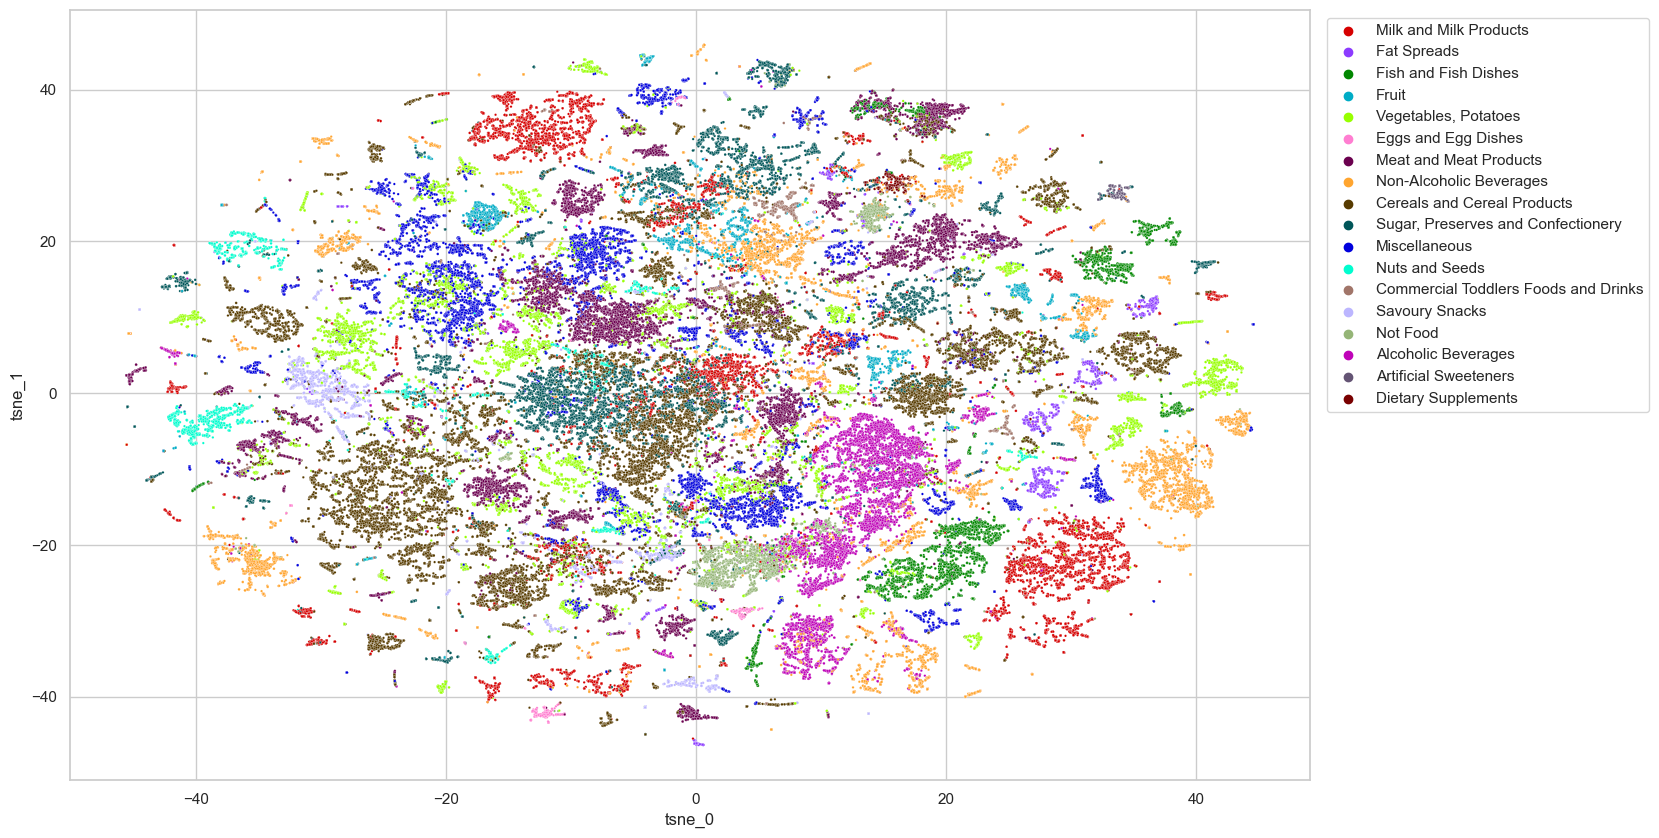

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=predicted_data['tsne_0'], y=predicted_data['tsne_1'],
    hue=predicted_data['parentcategory_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=18), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [10]:
# save level 0 categories
predicted_data.to_csv('../../SFS/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv', 
                      index=False)